Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
import joblib
import warnings
import warnings
warnings.filterwarnings('ignore')


Load required datasets

In [2]:
df = pd.read_csv('C:\\Users\\sanskruti\\OneDrive\\Desktop\\formula1csv\\merged.csv')  
df.head()


,year,race_name,race_date,circuit_name,driverId,driver_name,driver_nationality,constructor,grid,positionOrder,points,status,championship_position,championship_points
0,2013,Australian Grand Prix,03/17/2013,Albert Park Grand Prix Circuit,3,Nico Rosberg,German,Mercedes,6,20,0,Electrical,20,0
1,2004,Australian Grand Prix,07-03-2004,Albert Park Grand Prix Circuit,44,Olivier Panis,French,Toyota,18,13,0,+2 Laps,13,0
2,2005,Australian Grand Prix,06-03-2005,Albert Park Grand Prix Circuit,14,David Coulthard,British,Red Bull,5,4,5,Finished,4,5
3,2000,Australian Grand Prix,12-03-2000,Albert Park Grand Prix Circuit,25,Alexander Wurz,Austrian,Benetton,14,7,0,Finished,7,0
4,2015,Australian Grand Prix,03/15/2015,Albert Park Grand Prix Circuit,13,Felipe Massa,Brazilian,Williams,3,4,12,Finished,4,12


Clean and encoding process

In [3]:
# Drop irrelevant or leakage columns
df = df.drop(['race_name', 'race_date'], axis=1, errors='ignore')

# Encode categorical columns
cat_cols = df.select_dtypes(include='object').columns
encoders = {}

for col in cat_cols:
    enc = LabelEncoder()
    df[col] = enc.fit_transform(df[col])
    encoders[col] = enc  # Save encoders for later use

# Define features and label
X = df.drop('positionOrder', axis=1)
y = df['positionOrder'].clip(upper=10) - 1  # Now classes are 0–9




Split and train

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Train the XGBoost Model

In [5]:
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=10,
    eval_metric='mlogloss',
    learning_rate=0.1,
    max_depth=6,
    n_estimators=150,
    use_label_encoder=False,
    random_state=42
)

model.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_class=10, num_parallel_tree=None, ...)

Evaluate the Model

In [6]:
y_pred = model.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))


Accuracy Score: 0.885
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.80      1.00      0.89         8
           2       0.83      0.71      0.77         7
           3       0.75      0.75      0.75         8
           4       0.92      1.00      0.96        12
           5       0.89      0.89      0.89         9
           6       1.00      0.70      0.82        10
           7       1.00      0.33      0.50         9
           8       0.00      0.00      0.00         8
           9       0.90      1.00      0.95       122

    accuracy                           0.89       200
   macro avg       0.81      0.72      0.74       200
weighted avg       0.86      0.89      0.86       200



Saving prediction model and encoders for futher predictions

In [7]:
joblib.dump(model, 'f1_position_model.pkl')


['f1_position_model.pkl']

Load Model Later

In [8]:
model = joblib.load('f1_position_model.pkl')


 Make a Prediction on New Sample

In [9]:
# Example: Use one row from test set
sample = X_test.iloc[[0]]
prediction = model.predict(sample)

print("Predicted Final Position (1–10):", prediction[0] + 1)


Predicted Final Position (1–10): 3


Plotting feature importance and confusion matrix

<Figure size 864x576 with 0 Axes>

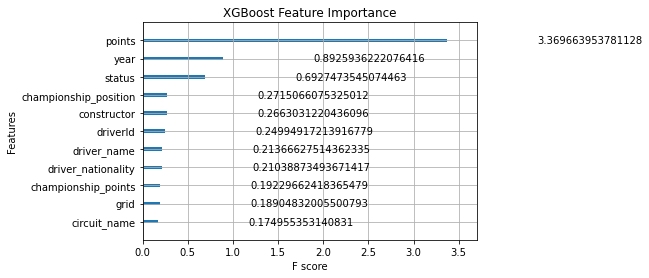

In [10]:
# Assuming your model is already trained:
model = XGBClassifier(eval_metric='mlogloss')
model.fit(X_train, y_train)

# Plot feature importance
plt.figure(figsize=(12, 8))
plot_importance(model, max_num_features=15, importance_type='gain')  # or 'weight', 'cover'
plt.title('XGBoost Feature Importance')
plt.show()

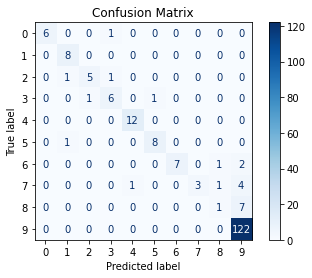

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on test set
y_pred = model.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.title('Confusion Matrix')
plt.show()
